<a href="https://colab.research.google.com/github/PurnimaJai/dwdm/blob/main/resume_selector_with_naive_bayes_kneighbours_logisticregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
pip install jupyterthemes

In [3]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 

In [6]:
# load the data
resume_df = pd.read_csv('/content/sample_data/Sheet_2.csv', encoding = 'latin-1')
resume_df

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...
...,...,...,...
120,resume_121,not_flagged,\rBrattleboro VT - Email me on Indeed: indeed....
121,resume_122,not_flagged,\rResearch and Teaching Assistant - University...
122,resume_123,not_flagged,\rMedical Coder - Highly Skilled - Entry Level...
123,resume_124,flagged,\rWaterbury VT - Email me on Indeed: indeed.co...


In [7]:
# dropping the resume_id attribute
resume_df = resume_df[['resume_text', 'class' ]]
resume_df

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,not_flagged
1,\rEngineer / Scientist - IBM Microelectronics ...,not_flagged
2,\rLTS Software Engineer Computational Lithogra...,not_flagged
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,not_flagged
4,\rIndependent Consultant - Self-employed\rBurl...,flagged
...,...,...
120,\rBrattleboro VT - Email me on Indeed: indeed....,not_flagged
121,\rResearch and Teaching Assistant - University...,not_flagged
122,\rMedical Coder - Highly Skilled - Entry Level...,not_flagged
123,\rWaterbury VT - Email me on Indeed: indeed.co...,flagged


In [8]:
# print first and last elements of the dataframe
resume_df.head(10)

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,not_flagged
1,\rEngineer / Scientist - IBM Microelectronics ...,not_flagged
2,\rLTS Software Engineer Computational Lithogra...,not_flagged
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,not_flagged
4,\rIndependent Consultant - Self-employed\rBurl...,flagged
5,\rPoultney VT - Email me on Indeed: indeed.com...,not_flagged
6,\rMedical Laboratory Scientist (Special Chemis...,not_flagged
7,Statistician\rBurlington VT - Email me on Inde...,flagged
8,Research technician\rBurlington VT - Email me ...,not_flagged
9,Barbara Hennessey-Elzohairy\rNewport VT - Emai...,not_flagged


In [9]:
resume_df.tail(10)

,resume_text,class
115,\rEssex Jct VT - Email me on Indeed: indeed.co...,flagged
116,Postdoctoral Associate - University of Vermon...,not_flagged
117,\rSpatial Analyst and UAV Flight Operator - Sp...,flagged
118,| Bioinformatics Analyst\rBurlington VT - Ema...,flagged
119,Professional\rNewbury VT - Email me on Indeed:...,not_flagged
120,\rBrattleboro VT - Email me on Indeed: indeed....,not_flagged
121,\rResearch and Teaching Assistant - University...,not_flagged
122,\rMedical Coder - Highly Skilled - Entry Level...,not_flagged
123,\rWaterbury VT - Email me on Indeed: indeed.co...,flagged
124,\rResearch and Development Scientist - Burling...,not_flagged


In [10]:
# obtain dataframe information
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   resume_text  125 non-null    object
 1   class        125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [11]:
# there are no null values in this data set so data cleaning to remove null values isn't required
# checking for number of null values
resume_df.isnull().sum()

resume_text    0
class          0
dtype: int64

In [12]:
# get how many flagged and how many not_flagged resumes exist in the dataset
# shows that this is an unbalanced dataset
resume_df['class'].value_counts()

not_flagged    92
flagged        33
Name: class, dtype: int64

In [13]:
# converting nominal to binary data -> class: flagged to 1 and not flagged to 0
resume_df['class'] = resume_df['class'].apply(lambda x:1 if x == 'flagged' else 0)
resume_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
4,\rIndependent Consultant - Self-employed\rBurl...,1
...,...,...
120,\rBrattleboro VT - Email me on Indeed: indeed....,0
121,\rResearch and Teaching Assistant - University...,0
122,\rMedical Coder - Highly Skilled - Entry Level...,0
123,\rWaterbury VT - Email me on Indeed: indeed.co...,1


In [14]:
# divide the dataset into two, one containing flagged resumes
# and the other containing non flagged resumes
class_0_df = resume_df[resume_df['class'] == 0]
class_0_df

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
5,\rPoultney VT - Email me on Indeed: indeed.com...,0
...,...,...
119,Professional\rNewbury VT - Email me on Indeed:...,0
120,\rBrattleboro VT - Email me on Indeed: indeed....,0
121,\rResearch and Teaching Assistant - University...,0
122,\rMedical Coder - Highly Skilled - Entry Level...,0


In [15]:
class_1_df = resume_df[resume_df['class'] == 1]
class_1_df

,resume_text,class
4,\rIndependent Consultant - Self-employed\rBurl...,1
7,Statistician\rBurlington VT - Email me on Inde...,1
10,Barbara Kurth\rResearch Assistant Professor Cl...,1
15,Caroline Clauson Work Study Student\rBrattlebo...,1
17,Chelsea Martin\rEnvironmental Scientist - Vana...,1
18,Christopher Fusting Data Science Consultant\rB...,1
23,David Grass\rCity Research Scientist - Environ...,1
24,David Lucero Public Health Analyst\rBurlington...,1
27,Drew Burkhard\rEnvironmental Scientist Meets M...,1
31,Eric Anderson Data Scientist\rBrattleboro VT -...,1


In [16]:
len(class_1_df)

33

In [17]:
# remove the \r in resume_text
resume_df['resume_text'] = resume_df['resume_text'].apply(lambda x: x.replace('\r', ''))
resume_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,resume_text,class
0,Customer Service Supervisor/Tier - Isabella Ca...,0
1,Engineer / Scientist - IBM Microelectronics Di...,0
2,LTS Software Engineer Computational Lithograph...,0
3,TUTORWilliston VT - Email me on Indeed: indee...,0
4,Independent Consultant - Self-employedBurlingt...,1
...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0
121,Research and Teaching Assistant - University o...,0
122,Medical Coder - Highly Skilled - Entry LevelSu...,0
123,Waterbury VT - Email me on Indeed: indeed.com/...,1


In [18]:
# download nltk packages
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
# download nltk packages
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# Get additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'email', 'com'])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [21]:
# Remove stop words and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return ' '.join(result)

In [22]:
# cleaned text
resume_df['cleaned'] = resume_df['resume_text'].apply(preprocess)

In [23]:
resume_df

,resume_text,class,cleaned
0,Customer Service Supervisor/Tier - Isabella Ca...,0,customer service supervisor tier isabella cata...
1,Engineer / Scientist - IBM Microelectronics Di...,0,engineer scientist ibm albert gregoritsch ecaw...
2,LTS Software Engineer Computational Lithograph...,0,lts software engineer computational lithograph...
3,TUTORWilliston VT - Email me on Indeed: indee...,0,tutorwilliston alec schwartz awork college bio...
4,Independent Consultant - Self-employedBurlingt...,1,independent consultant self alex reutter fefwo...
...,...,...,...
120,Brattleboro VT - Email me on Indeed: indeed.co...,0,brattleboro bcc skilled presenter trainer micr...
121,Research and Teaching Assistant - University o...,0,research teaching assistant university cdd gra...
122,Medical Coder - Highly Skilled - Entry LevelSu...,0,medical coder highly skilled entry levelsudbur...
123,Waterbury VT - Email me on Indeed: indeed.com/...,1,waterbury bec fcwilling relocate work employer...


In [24]:
print(resume_df['resume_text'][0])

Customer Service Supervisor/Tier - Isabella Catalog CompanySouth Burlington VT - Email me on Indeed: indeed.com/r//49f8c9aecf490d26WORK EXPERIENCECustomer Service Supervisor/TierIsabella Catalog Company - Shelburne VT - August 2015 to Present2 Customer Service/Visual Set Up & Display/Website Maintenance¢ Supervise customer service team of a popular catalog company¢ Manage day to day issues and resolution of customer upset to ensure customer satisfaction¢ Troubleshoot order and shipping issues: lost in transit order errors damages¢ Manage and resolve escalated customer calls to ensure customer satisfaction¢ Assist customers with order placing cross-selling/upselling of catalog merchandise¢ Set up and display of sample merchandise in catalog library as well as customer pick-up area of the facility ¢ Website clean-up: adding images type up product information proofreadingAdministrative Assistant /Events Coordinator/Office Services AssistantEileen Fisher Inc - Irvington NY - 

In [25]:
print(resume_df['cleaned'][0])

customer service supervisor tier isabella catalog companysouth burlington aecf work service supervisor tierisabella catalog company shelburne august present customer service visual set display website maintenance supervise customer service team popular catalog company manage day day issues resolution customer upset ensure customer satisfaction troubleshoot order shipping issues lost transit order errors damages manage resolve escalated customer calls ensure customer satisfaction assist customers order placing cross selling upselling catalog merchandise set display sample merchandise catalog library customer pick area facility website clean adding images type product information assistant events coordinator office services assistanteileen fisher irvington february july support director architecture architecture coordinator daily activities including preparing monthly expense reports scheduling calendar maintenance arranging aspects travel logistics catering interior design research proj

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


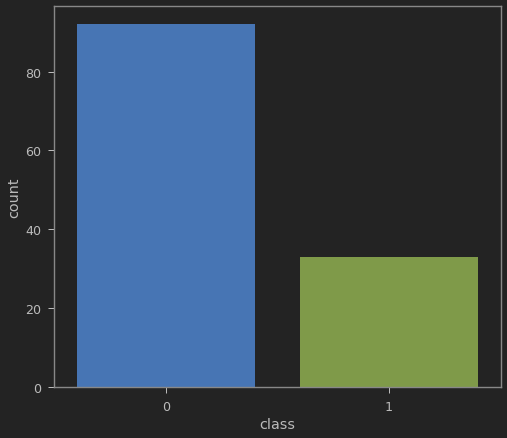

In [26]:
# visualizing cleaned dataset
# Plot the counts of flagged vs not flagged
sns.countplot(resume_df['class'], label = 'Count Plot')

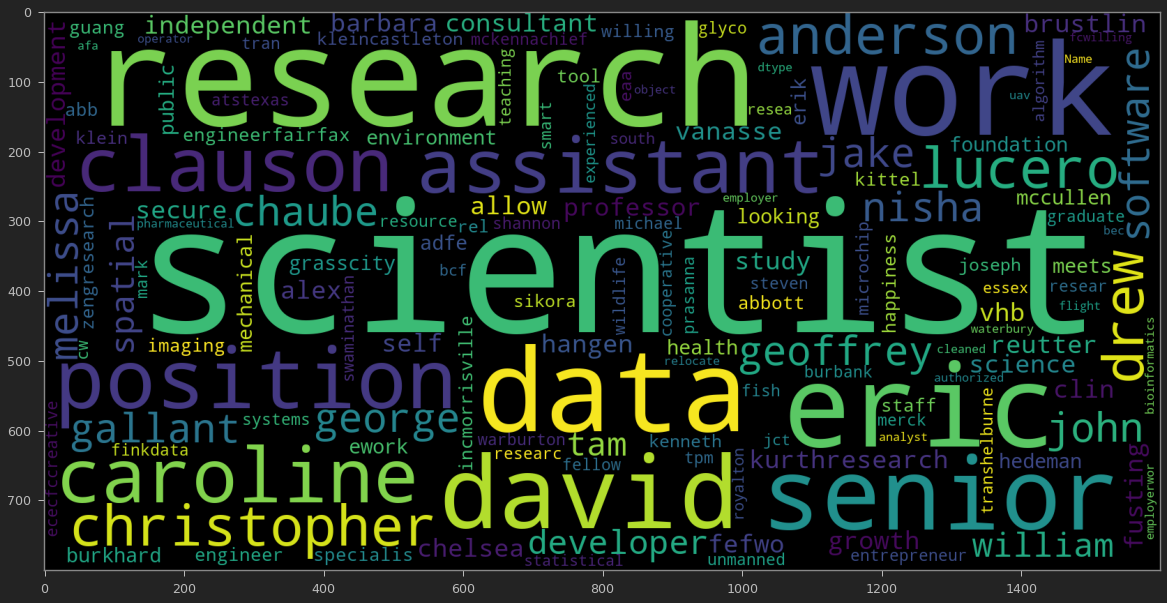

In [27]:
# plot the word cloud for text that is flagged
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop_words).generate(str(resume_df[resume_df['class'] == 1].cleaned))
plt.imshow(wc)

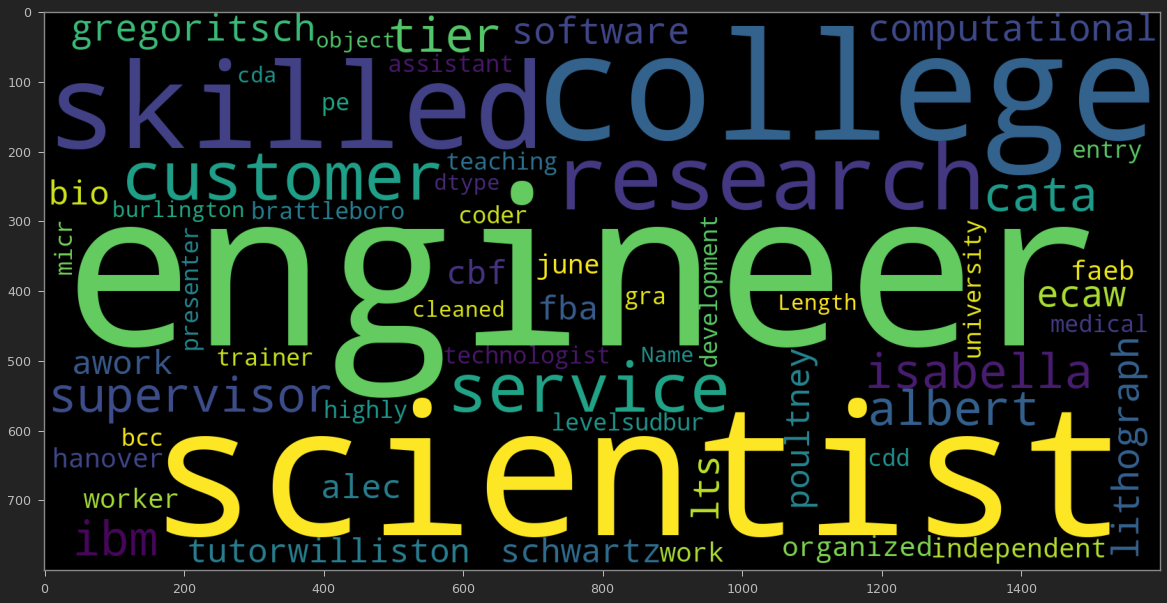

In [28]:
# wordcloud for class 0
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop_words).generate(str(resume_df[resume_df['class'] == 0].cleaned))
plt.imshow(wc)

In [29]:
# preparing data by count vectorizing
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
countvectorizer = vectorizer.fit_transform(resume_df['cleaned'])

In [30]:
print(vectorizer.get_feature_names_out())

['aaalac' 'aabb' 'aac' ... 'ãæcomputer' 'ètravel' 'ô_torrent']


In [31]:
#deprecated method
print(vectorizer.get_feature_names())

['aaalac', 'aabb', 'aac', 'aacn', 'aacr', 'aacrjournals', 'aakeroõ_y', 'aanpcp', 'aaron', 'abbott', 'abdomen', 'abdominal', 'abdul', 'aberdeen', 'abi', 'abilities', 'ability', 'abiotic', 'able', 'abnormal', 'aboard', 'abosalem', 'abraham', 'abreast', 'abs', 'absence', 'absorbance', 'abstract', 'abstracta', 'abstractdisease', 'abstracted', 'abstractin', 'abstracts', 'abualrub', 'abundance', 'abureehan', 'abuse', 'abusiness', 'academia', 'academic', 'academics', 'academy', 'acaeefbc', 'accelerated', 'accept', 'acceptability', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessibility', 'accessible', 'accession', 'accident', 'accidents', 'accolateî', 'accommodations', 'accomplished', 'accomplishment', 'accomplishments', 'accord', 'accordance', 'according', 'accordingly', 'accords', 'account', 'accountability', 'accountable', 'accounted', 'accounting', 'accounts', 'accreditation', 'accredited', 'accrual', 'accumulation', 'accuracy', 'accurate', 'accurately', 'accustomed'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
print(countvectorizer.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
# using the count vectorized data to train the naive bayes model
# splitting the data into 80% training and 20% testing
X = countvectorizer
y = resume_df["class"]

In [34]:
X.shape

(125, 11315)

In [35]:
y.shape

(125,)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [61]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

prediction = NB_classifier.predict(X_test)

print('Accuracy of NaiveBayes Classifier on training set: {:.2f}'.format(NB_classifier.score(X_train, y_train)))
print('Accuracy of NaiveBayes Classifier on test set: {:.2f}'.format(NB_classifier.score(X_test, y_test)))
print("\n Classification report for classifier %s:\n%s\n" % (NB_classifier, metrics.classification_report(y_test, prediction)))

Accuracy of NaiveBayes Classifier on training set: 1.00
Accuracy of NaiveBayes Classifier on test set: 0.76

 Classification report for classifier MultinomialNB():
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.43      0.60      0.50         5

    accuracy                           0.76        25
   macro avg       0.66      0.70      0.67        25
weighted avg       0.80      0.76      0.77        25




In [62]:
# sanity check
X_train.shape

(100, 11315)

In [39]:
X_test.shape

(25, 11315)

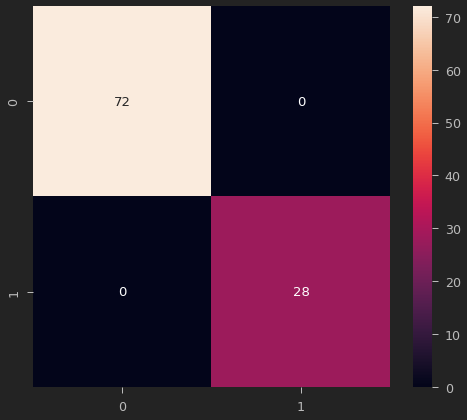

In [60]:
# assess the performance of the trained model
# Predicting the performance on train data
y_predict_train = NB_classifier.predict(X_train)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot = True)

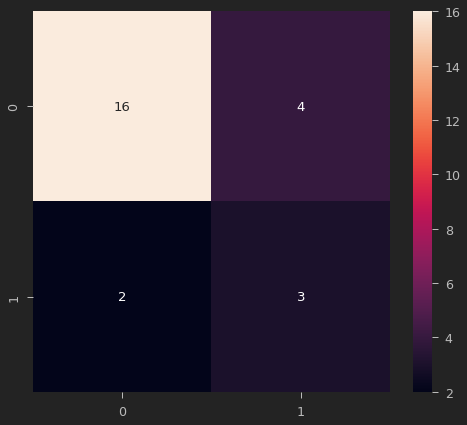

In [63]:
# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)

In [52]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


KN_Classifier = OneVsRestClassifier(KNeighborsClassifier())

KN_Classifier.fit(X_train,y_train)
prediction = KN_Classifier.predict(X_test)

print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(KN_Classifier.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(KN_Classifier.score(X_test, y_test)))
print("\n Classification report for classifier %s:\n%s\n" % (KN_Classifier, metrics.classification_report(y_test, prediction)))

Accuracy of KNeighbors Classifier on training set: 0.86
Accuracy of KNeighbors Classifier on test set: 0.72

 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.40      0.80      0.53         5

    accuracy                           0.72        25
   macro avg       0.67      0.75      0.67        25
weighted avg       0.83      0.72      0.75        25




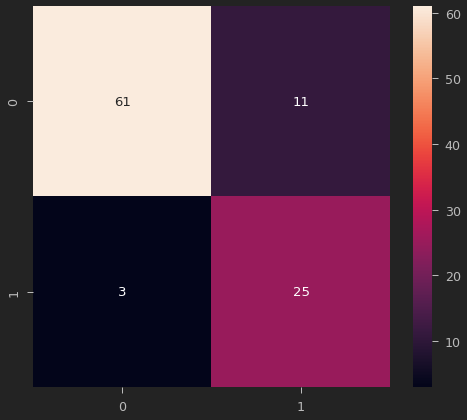

In [53]:
# assess the performance of the trained model
# Predicting the performance on train data
y_predict_train = KN_Classifier.predict(X_train)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot = True)

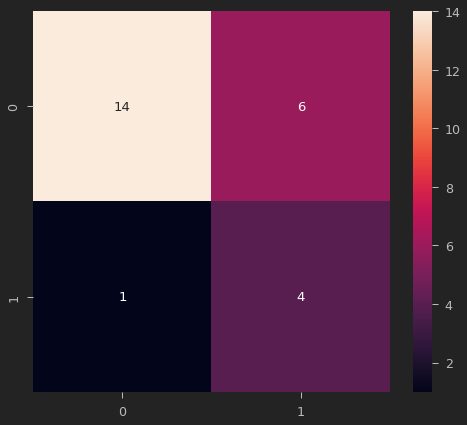

In [58]:
# Predicting the Test set results
y_predict_test = KN_Classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)

In [56]:
from sklearn.linear_model import LogisticRegression

LR_Model = LogisticRegression(penalty='l2',tol=0.00001,solver='sag',C=1.0,max_iter=10000,random_state=33)
LR_Model.fit(X_train, y_train)

prediction = LR_Model.predict(X_test)

print('Accuracy of LogisticRegression Classifier on training set: {:.2f}'.format(LR_Model.score(X_train, y_train)))
print('Accuracy of LogisticRegression Classifier on test set: {:.2f}'.format(LR_Model.score(X_test, y_test)))
print("\n Classification report for classifier %s:\n%s\n" % (LR_Model, metrics.classification_report(y_test, prediction)))

Accuracy of LogisticRegression Classifier on training set: 1.00
Accuracy of LogisticRegression Classifier on test set: 0.84

 Classification report for classifier LogisticRegression(max_iter=10000, random_state=33, solver='sag', tol=1e-05):
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.57      0.80      0.67         5

    accuracy                           0.84        25
   macro avg       0.76      0.82      0.78        25
weighted avg       0.87      0.84      0.85        25




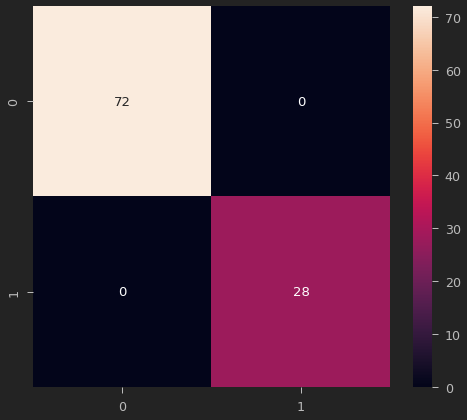

In [50]:
# assess the performance of the trained model
# Predicting the performance on train data
y_predict_train = LR_Model.predict(X_train)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot = True)

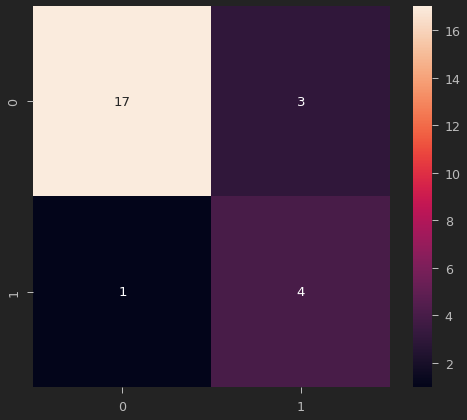

In [55]:
# Predicting the Test set results
y_predict_test = LR_Model.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot = True)